In [1]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import pandas as pd

np.random.seed(42)

## Average Treatment Effect Estimation 

The Average Treatment Effect is: $\tau = \mathbb{E}[Y_i^{(1)} - Y_i^{(0)}]$ where

- $Y_i^{(1)}$ is potential outcome for unit $i$ under treatment 
- $Y_i^{(0)}$ is potential outcome for unit $i$ under control

$T_i$ is the treatment assignment for unit $i$:

- $T_i=1$ if unit $i$ assigned to treatment
- $T_i=0$ if unit $i$ assigned to control

For each unit $i$, we only observe one of $Y_i^{(1)}, Y_i^{(0)}$.

### Randomized Treatment

We first consider a randomized treatment (no confounding). That is:

$Y_i^{(1)}, Y_i^{(0)} \text{ ind } T_i$.

In [2]:
n = 500

# randomly draw treatment
t = np.random.binomial(1, 0.5, size=n)

# treatment effect
tau = 4

# outcome
y = tau * t + np.random.normal(size=n)

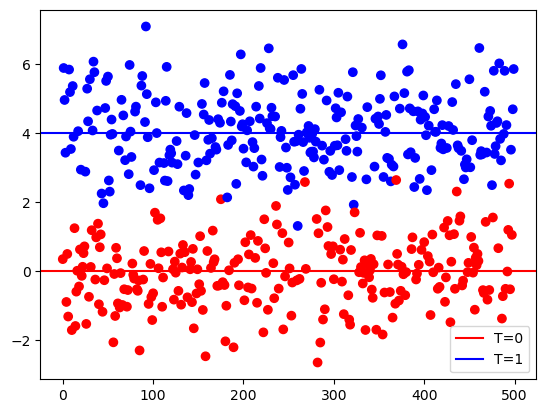

In [3]:
plt.scatter(range(n), y, c=['red' if i == 0 else 'blue' for i in t], marker='o')
plt.axhline(y = 0, color = 'red', label='T=0')
plt.axhline(y = tau, color = 'blue',label='T=1')
plt.legend()

Because $\mathbb{E}[Y_i|T_i=1]-\mathbb{E}[Y_i|T_i=0] = \mathbb{E}[Y_i^{(1)}=Y_i^{(0)}]$, we can estimate the ATE by taking the difference in means:

In [4]:
np.mean(y[t==1]) - np.mean(y[t==0])

np.float64(4.102895888143023)

This is equivalent to fitting a linear model with an intercept.

In [5]:
T = sm.add_constant(t)
model = sm.OLS(y, T).fit()
model.params

array([-0.04568022,  4.10289589])

Permutation test for $H_0: \tau = 0$ vs. $H_1: \tau \neq 0$

In [6]:
t_obs = np.mean(y[t==1]) - np.mean(y[t==0])

B = 1000
t_dist = np.zeros((B))

for b in range(B):
    t_draw = t[np.random.choice(n, size=n, replace=False)]
    t_dist[b] = np.mean(y[t_draw==1]- np.mean(y[t_draw==0]))

In [7]:
p_value = sum([1 for t in t_dist if t >= t_obs]) / B

print(f"P-Value: {p_value:.4f}")

P-Value: 0.0000


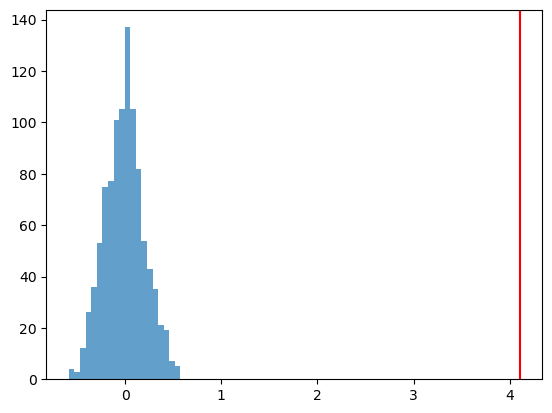

In [8]:
plt.hist(t_dist, bins=20, alpha=0.7)
plt.axvline(t_obs, color='red')
plt.show()

### Observed confounder

Suppose we have an observed confounder, $X$. 

If we know $X$ affects $Y$ linearly, we can fit the model:

$Y_i = \beta X_i + \tau T_i + \varepsilon_i$,

where $\varepsilon_i$ is Gaussian noise. 

In [9]:
n = 500
x = np.random.uniform(-3, 3, n)
t = 1 * (x < 0) # if x < 0, you get the treatment, otherwise you get control

In [10]:
tau = 4
y = x + tau * t + np.random.normal(size=n)

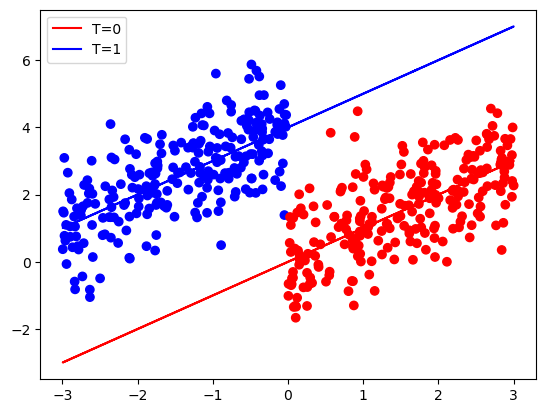

In [11]:
plt.scatter(x, y, c=['red' if i == 0 else 'blue' for i in t], marker='o')
plt.plot(x, x, color = 'red', label='T=0')
plt.plot(x, x + tau, color = 'blue', label='T=1')
plt.legend()

If we do not adjust for $X$, we do not get the correct treatment effect:

In [12]:
# no adjustment for x
np.mean(y[t==1]) - np.mean(y[t==0])

np.float64(1.055527008176574)

Adjusting for $X$, we get the correct treatment effect:

In [13]:
df = pd.DataFrame({'t': t, 'x': x})
model = sm.OLS(y, df).fit()
model.params

t    4.064826
x    1.022550
dtype: float64

Another way to calculate the treatment effect, adjusting for $X$:

In [14]:
x = x.reshape(n, 1)
H = x @ np.linalg.inv(x.T @ x) @ x.T
# H = X(t(X)X)^{-1}t(X)

In [15]:
y_adj = (np.eye(n) - H) @ y # residuals after regression on x
t_adj = (np.eye(n) - H) @ t # residuals after regression on x

In [16]:
model = sm.OLS(y_adj, t_adj).fit()
model.params

array([4.06482618])

### Propensity score

We could also use the propensity score to account for observed confounding, provided we have overlap. 

We generate a simulated dataset:

In [17]:
x = np.random.uniform(-3, 3, n)

t_prob = 1/(1 + np.exp(-x)) # exp(x)/(1+exp(x)) -- this is the link function from logistic regression
t = np.random.binomial(1, t_prob, n)

tau = 4
y = x + tau * t + np.random.normal(size=n)

For this simulated data, we check our min and max propensity scores to make sure overlap is satisfied. (That is, we can't have $P(T=1|X=x)=0$ or $1$.)

In [29]:
print(f"Min propensity: {t_prob.min():.4f}, Max propensity: {t_prob.max():.4f}")

Min propensity: 0.0474, Max propensity: 0.9514


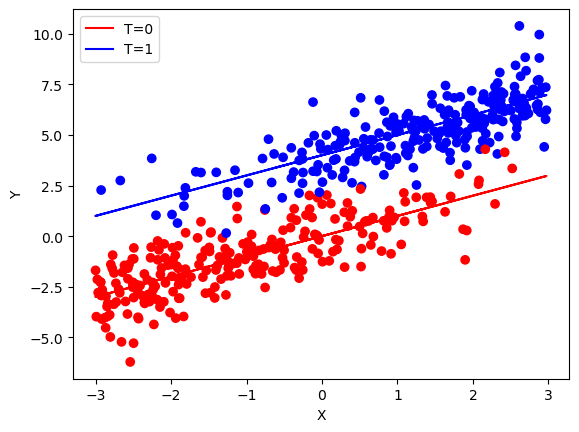

In [18]:
# Plotting
plt.scatter(x, y, c=['red' if i == 0 else 'blue' for i in t], marker='o')
plt.plot(x, x, color='red', label='T=0')
plt.plot(x, x + tau, color='blue', label='T=1')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

In practice, we do not know the propensity score. We estimate the propensity score using logistic regression (i.e. $T$ vs. $X$).

In [19]:
# Propensity score model - logistic regression predicting T from X (no Y)
# q_hat(x) = estimated P(T=1 | X=x)

X_prop = sm.add_constant(x)
prop_model = sm.GLM(t, X_prop, family=sm.families.Binomial()).fit()

In [20]:
prop_score = prop_model.predict(X_prop)

Quick check: the estimated propensity score is close to the true propensity score:

Text(0, 0.5, 'True propensity')

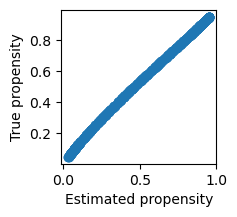

In [30]:
plt.figure(figsize=(2,2))
plt.scatter(prop_score, t_prob)
plt.xlabel('Estimated propensity')
plt.ylabel('True propensity')

We now calculate the inverse probability weighting estimator as an estimator of the ATE:

$IPW = \frac{1}{n}\sum_{i=1}^n \frac{T_i Y_i}{q(T_i|X_i)} + \frac{(1-T_i)Y_i}{(1-q(T_i|X_i))}$

In [22]:
# Inverse probability weighting (IPW)
ipw = y * t / prop_score - (1 - t) * y / (1 - prop_score)

# if t = 1, y/prop_score, if t = 0, y/(1-prop_score)

print("Mean of IPW:", np.mean(ipw))

Mean of IPW: 4.115397597113825


### Colliders 

What happens if we have a collider (instead of a confounder)?

We should NOT adjust for colliders. Let's see what happens if we do in simulated data.

In [23]:
n = 500

# randomly draw treatment
t = np.random.binomial(1, 0.5, size=n)

# treatment effect
tau = 4

# outcome
y = tau * t + np.random.normal(size=n)

x = t + 0.5 * y + np.random.normal(scale = 0.2, size = n)

To estimate ATE, take difference in means of treatment and control:

In [24]:
np.mean(y[t==1]) - np.mean(y[t==0])

np.float64(4.072612320862982)

If we mistakenly include $X$, we do not estimate the ATE well (the estimate is negative instead of positive!)

In [25]:
df = pd.DataFrame({'t': t, 'x': x})
model = sm.OLS(y, df).fit()
model.params

t   -1.193571
x    1.743958
dtype: float64

#### Another example of a collider

Here, the true treatment effect is zero.

In [26]:
n = 500

# randomly draw treatment
t = np.random.binomial(1, 0.5, size=n)

# treatment effect
tau = 0

# outcome
y = tau * t + np.random.normal(size=n)

x = t + 0.5 * y + np.random.normal(scale = 0.2, size = n)

The difference in means of treatment and control is unbiased for the ATE:

In [27]:
np.mean(y[t==1]) - np.mean(y[t==0])

np.float64(-0.06499427497289205)

But if we mistakenly condition on the collider, we have a non-zero estimate, which is wrong.

In [28]:
df = pd.DataFrame({'t': t, 'x': x})
model = sm.OLS(y, df).fit()
model.params

t   -1.725415
x    1.713434
dtype: float64